# Install neccessary packages

# Config

In [7]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = None
presets = "experimental_zeroshot_hpo_hybrid"#'best_quality'

use_is_estimated_attr = True

drop_night_outliers = True

# to_drop = ["snow_drift:idx", "snow_density:kgm3", "wind_speed_w_1000hPa:ms", "dew_or_rime:idx", "prob_rime:p", "fresh_snow_12h:cm", "fresh_snow_24h:cm", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms", "snow_melt_10min:mm", "rain_water:kgm2", "dew_point_2m:K", "precip_5min:mm", "absolute_humidity_2m:gm3", "air_density_2m:kgm3"]#, "msl_pressure:hPa", "pressure_50m:hPa",  "pressure_100m:hPa"]
to_drop = ["wind_speed_w_1000hPa:ms", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms", "snow_density:kgm3", "cloud_base_agl:m", "ceiling_height_agl:m"]

excluded_model_types = ['CAT', 'XGB', 'RF']

num_stack_levels = 0
num_bag_folds = 8#8# 8
num_bag_sets = 3##20

use_tune_data = True
use_test_data = True
use_bag_holdout = True 

clip_predictions = True

# Loading and preprocessing

In [8]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")


def feature_engineering(X):
    # shift columns with them by 1 hour, so that for index 16:00, we have the values from 17:00
    columns = ['clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J',
               'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
               'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

    # Filter rows where index.minute == 0
    X_shifted = X[X.index.minute == 0][columns].copy()

    # Create a set for constant-time lookup
    index_set = set(X.index)

    # Vectorized time shifting
    one_hour = pd.Timedelta('1 hour')
    shifted_indices = X_shifted.index #+ one_hour
    X_shifted.loc[shifted_indices.isin(index_set)] = X.loc[shifted_indices[shifted_indices.isin(index_set)]][columns]

    # set last row to same as second last row
    X_shifted.iloc[-1] = X_shifted.iloc[-2]


    # Rename columns
    X_old_unshifted = X_shifted.copy()
    X_old_unshifted.columns = [f"{col}_not_shifted" for col in X_old_unshifted.columns]
    
    date_calc = None
    # If 'date_calc' is present, handle it
    if 'date_calc' in X.columns:
        date_calc = X[X.index.minute == 0]['date_calc']


  

    # resample to hourly
    X = X.resample('H').mean()

    # overwrite columns with shifted columns
    X[columns] = X_shifted[columns]

    if date_calc is not None:
        X['date_calc'] = date_calc

    return X




def fix_X(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    
    X = feature_engineering(X)

    return X



def handle_features(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_X(X_train_observed, "X_train_observed")
    X_train_estimated = fix_X(X_train_estimated, "X_train_estimated")
    X_test = fix_X(X_test, "X_test")


    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = handle_features(X_train_observed, X_train_estimated, X_test, y_train)

    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1

    # drop date_calc
    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)


    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    
    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test

# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Processing location B...
Processing location C...


## Feature enginering

### Remove anomalies

In [9]:
import pandas as pd

def replace_streaks_with_nan(df, max_streak_length, column="y"):
    for location in df["location"].unique():
        x = df[df["location"] == location][column].copy()

        last_val = None
        streak_length = 1
        streak_indices = []
        allowed = [0]
        found_streaks = {}

        for idx in x.index:
            value = x[idx]

            if value == last_val and value not in allowed:
                streak_length += 1
                streak_indices.append(idx)
            else:
                streak_length = 1
                last_val = value
                streak_indices.clear()

            if streak_length > max_streak_length:
                found_streaks[value] = streak_length

                for streak_idx in streak_indices:
                    x[idx] = np.nan
                streak_indices.clear()  # clear after setting to NaN to avoid setting multiple times
        df.loc[df["location"] == location, column] = x

        print(f"Found streaks for location {location}: {found_streaks}")

    return df


X_train = replace_streaks_with_nan(X_train.copy(), 3, "y")

Found streaks for location A: {}
Found streaks for location B: {3.45: 28, 6.9: 7, 12.9375: 5, 13.8: 8, 276.0: 78, 18.975: 58, 0.8625: 4, 118.1625: 33, 34.5: 11, 183.7125: 1058, 87.1125: 7, 79.35: 34, 7.7625: 12, 27.6: 448, 273.41249999999997: 72, 264.78749999999997: 55, 169.05: 33, 375.1875: 56, 314.8125: 66, 76.7625: 10, 135.4125: 216, 81.9375: 202, 2.5875: 12, 81.075: 210}
Found streaks for location C: {9.8: 4, 29.400000000000002: 4, 19.6: 4}


In [10]:
# print num rows
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))


Dropped rows:  9285


In [11]:
thresh = 0.1
mask = (X_train["direct_rad_1h:J"] <= thresh) & (X_train["diffuse_rad_1h:J"] <= thresh) & (X_train["y"] >= 0.1)

if drop_night_outliers:
    X_train.loc[mask, "y"] = np.nan

In [12]:
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))

Dropped rows:  1876


In [13]:
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

In [14]:
def split_and_shuffle_data(input_data, num_bins, frac1):
    # Validate the input fraction
    if frac1 < 0 or frac1 > 1:
        raise ValueError("frac1 must be between 0 and 1.")
    
    if frac1==1:
        return input_data, pd.DataFrame()

    # Calculate the fraction for the second output set
    frac2 = 1 - frac1
    
    # Calculate bin size
    bin_size = len(input_data) // num_bins

    # Initialize empty DataFrames for output
    output_data1 = pd.DataFrame()
    output_data2 = pd.DataFrame()

    for i in range(num_bins):
        # Shuffle the data in the current bin
        np.random.seed(i)
        current_bin = input_data.iloc[i * bin_size: (i + 1) * bin_size].sample(frac=1)
        
        # Calculate the sizes for each output set
        size1 = int(len(current_bin) * frac1)
        
        # Split and append to output DataFrames
        output_data1 = pd.concat([output_data1, current_bin.iloc[:size1]])
        output_data2 = pd.concat([output_data2, current_bin.iloc[size1:]])

    # Shuffle and split the remaining data
    remaining_data = input_data.iloc[num_bins * bin_size:].sample(frac=1)

    remaining_size1 = int(len(remaining_data) * frac1)
    
    output_data1 = pd.concat([output_data1, remaining_data.iloc[:remaining_size1]])
    output_data2 = pd.concat([output_data2, remaining_data.iloc[remaining_size1:]])

    return output_data1, output_data2


In [15]:
from autogluon.tabular import TabularDataset, TabularPredictor
data = TabularDataset('X_train_raw.csv')
data['ds'] = pd.to_datetime(data['ds'])
data = data.sort_values(by='ds')

split_time = pd.to_datetime("2022-10-28 22:00:00")
train_set = TabularDataset(data[data["ds"] < split_time])
estimated_set = TabularDataset(data[data["ds"] >= split_time]) # only estimated

test_set = pd.DataFrame()
tune_set = pd.DataFrame()
new_train_set = pd.DataFrame()

for location in locations:
    loc_data = data[data["location"] == location]
    num_train_rows = len(loc_data)
    
    tune_rows = 1500.0 # 2500.0
    if use_test_data:
        tune_rows = 1880.0#max(3000.0, len(estimated_set[estimated_set["location"] == location]))

    holdout_frac = max(0.01, min(0.1, tune_rows / num_train_rows)) * num_train_rows / len(estimated_set[estimated_set["location"] == location])

    # shuffle and split data
    loc_tune_set, loc_new_train_set = split_and_shuffle_data(estimated_set[estimated_set['location'] == location], 40, holdout_frac)

    new_train_set = pd.concat([new_train_set, loc_new_train_set])

    if use_test_data:
        loc_test_set, loc_tune_set = split_and_shuffle_data(loc_tune_set, 40, 0.2)
        test_set = pd.concat([test_set, loc_test_set])

    tune_set = pd.concat([tune_set, loc_tune_set])

# add rest to train_set
train_set = pd.concat([train_set, new_train_set])
tuning_data = tune_set
if use_test_data:
    test_data = test_set

train_data = train_set

train_data = TabularDataset(train_data)
tuning_data = TabularDataset(tuning_data)

if use_test_data:
    test_data = TabularDataset(test_data)

In [16]:
train_data.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,...,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,is_estimated,y
count,82388.000000,82388.000000,8.238800e+04,82388.000000,82388.000000,82388.000000,82388.000000,8.238800e+04,82388.000000,8.238800e+04,...,82388.000000,82388.000000,82388.000000,82388.000000,82388.000000,82388.000000,82388.000000,82388.000000,82388.000000,82388.000000
mean,6.063501,1.254276,5.342796e+05,148.333766,0.006257,275.360024,40.589171,1.467006e+05,52.258569,1.879394e+05,...,0.090876,181.581020,-1.009787,0.057907,279.576985,73.810239,33143.342108,3.034774,0.062376,308.954471
std,2.713909,0.036723,8.339391e+05,231.776450,0.233177,6.831039,61.321282,2.185462e+05,115.162620,4.095591e+05,...,0.239902,97.294305,24.326501,0.106671,6.561283,33.848610,17961.262682,1.750603,0.241838,799.279381
min,0.500000,1.139250,0.000000e+00,0.000000,-1.000000,247.425000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000,6.983000,-49.932000,0.000000,258.025000,0.000000,132.375000,0.025000,0.000000,-0.000000
25%,4.075000,1.229250,0.000000e+00,0.000000,0.000000,270.900000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000,95.998750,-18.947750,0.000000,275.050000,53.700000,16778.524250,1.675000,0.000000,0.000000
50%,5.500000,1.253500,1.384550e+04,1.500000,0.000000,275.150000,0.800000,1.506420e+04,0.000000,0.000000e+00,...,0.000000,180.814750,-0.916375,0.000000,278.825000,92.950000,37183.275500,2.700000,0.000000,0.000000
75%,7.900000,1.277500,8.417266e+05,234.587500,0.000000,280.650000,67.800000,2.454400e+05,33.481250,1.267691e+05,...,0.100000,266.430130,16.155562,0.100000,284.125000,99.900000,48487.193750,4.050000,0.000000,186.200000
max,17.350000,1.441000,3.006697e+06,835.650000,1.000000,293.625000,334.750000,1.182250e+06,683.400000,2.445897e+06,...,5.650000,348.487520,49.943750,1.375000,303.250000,100.000000,75086.800000,13.275000,1.000000,5733.420000


# Modeling

In [17]:
import os


# if submissions folder does not exist, create it
if not os.path.exists('submissions'):
    os.makedirs('submissions')

# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

print("New filename:", new_filename)

Last submission number: 137
Now creating submission number: 138
New filename: submission_138


In [104]:
predictors = [None, None, None]

In [105]:
class ModelEnsemble:
    def __init__(self, catboost_model, fastai_learner):
        self.catboost_model = catboost_model
        self.fastai_learner = fastai_learner

    def predict(self, X):
        # Make predictions with both models
        catboost_preds = self.catboost_model.predict(X)
        fastai_preds = self.fastai_learner.predict(X)[0].cpu().detach().numpy()
        
        # Simple average ensemble
        ensemble_preds = (catboost_preds + fastai_preds) / 2
        return ensemble_preds


In [106]:
from fastai.tabular.all import TabularPandas, FillMissing, Normalize

def preprocess_data_fastai(train_data, tuning_data):
    # Define the pre-processing steps
    procs = [FillMissing, Normalize]

    # Since you mentioned no categorical variables, only numerical:
    cat_names = []  # No categorical variables
    cont_names = [col for col in train_data.columns if col not in [label, 'ds', 'location']]  # All other columns are continuous
    
    # Combine the train and tuning data
    all_data = pd.concat([train_data, tuning_data], axis=0).reset_index(drop=True)
    
    # Prepare the index for the validation set
    # The last len(tuning_data) indices will be for the validation set
    train_idxs = range(len(train_data))
    valid_idxs = range(len(train_data), len(all_data))
    
    # Prepare TabularPandas object
    to = TabularPandas(all_data, procs=procs, cat_names=cat_names, cont_names=cont_names,
                       y_names=label, splits=(list(train_idxs), list(valid_idxs)))
    
    return to

In [111]:
from fastai.tabular.all import tabular_learner, TabularPandas, Categorify, FillMissing, Normalize

def fit_predictor_for_location_fastai(train_data, tuning_data):
    # Preprocess the data
    to = preprocess_data_fastai(train_data, tuning_data)


    # Convert to DataLoaders
    dls = to.dataloaders(bs=64).to(torch.device('cpu'))
    
    # Define the FastAI tabular learner
    learn = tabular_learner(dls, layers=[200,100], metrics=mean_absolute_error)

    learn.model.to('cpu')
    
    # Train the FastAI model
    learn.fit_one_cycle(1, 1e-2)
    
    # Return the FastAI model
    return learn, to



In [112]:
from catboost import CatBoostRegressor  # or CatBoostClassifier
from sklearn.metrics import mean_absolute_error

def fit_predictor_for_location_catboost(loc):
    # Define CatBoost parameters with MAE as the evaluation metric
    catboost_params = {
        'loss_function': 'MAE',  # Specify Mean Absolute Error as loss function
        'iterations': 5000,
        #'learning_rate': 0.1,  # Moderate to low learning rate
        # 'depth': 8,  # Moderate tree depth
        'l2_leaf_reg': 6.0,  # L2 regularization
        # 'random_strength': 1,  # Some randomness
        # 'bootstrap_type': 'Bernoulli',  # Bootstrap type
        #'early_stopping_rounds': 200,  # Stop if validation doesn't improve for 50 iterations
    }

    # Initialize CatBoost model
    model = CatBoostRegressor(**catboost_params)  # Use CatBoostClassifier for classification tasks

    # Separate features and target for training data
    train_data_loc = train_data[train_data["location"] == loc]
    X_train = train_data_loc.drop(columns=["ds", label, "location"])  # Replace 'label' with your target column name
    y_train = train_data_loc[label]

    # Separate features and target for tuning data
    tuning_data_loc = tuning_data[tuning_data["location"] == loc]
    X_tuning = tuning_data_loc.drop(columns=["ds", label, "location"])
    y_tuning = tuning_data_loc[label]

    # Fit model
    model.fit(X_train, y_train, eval_set=(X_tuning, y_tuning))

    return model

In [126]:
def fit_predictor_for_location(loc):
    train_data_loc = train_data[train_data["location"] == loc]
    tuning_data_loc = tuning_data[tuning_data["location"] == loc]

    fastai_learner, to = fit_predictor_for_location_fastai(train_data_loc, tuning_data_loc)
    # Print with large letters and green color. Finished running torch.
    print("\033[1;32;40mFinished running torch.\033[0m")

    # Train CatBoost Model
    # catboost_model = fit_predictor_for_location_catboost(loc)


    # # Create the ensemble
    # ensemble = ModelEnsemble(catboost_model, torch_learner)

    # Evaluation
    if use_test_data:
        test_data_loc = test_data[test_data["location"] == loc]
        X_test = test_data_loc.drop(columns=["ds", label, "location"])
        y_test = test_data_loc[label]

        # Generate predictions
        # predictions_ensemble = ensemble.predict(X_test)
        # predictions_catboost = catboost_model.predict(X_test)

        to_test = to.new(X_test)
        to_test.process()

        dl_test = to_test.dataloaders(bs=64, shuffle=False, drop_last=False).to(torch.device('cpu'))

        # Collect predictions manually
        predictions = []
        for batch in dl_test:
            with torch.no_grad():  # Ensure we're in inference mode
                preds = fastai_learner.model(batch[0])  
                predictions.append(preds)
        predictions_fastai = torch.cat(predictions).numpy()


        # print("Preprocessed test data")
        # print(test_fastai)
        # predictions_fastai, _ = fastai_learner.get_preds(dl=test_fastai)
        # predictions_fastai = predictions_fastai.numpy()

        # Calculate MAE
        # mae = mean_absolute_error(y_test, predictions)
        # mae_catboost = mean_absolute_error(y_test, predictions_catboost)
        mae_fastai = mean_absolute_error(y_test, predictions_fastai)
        print("Evaluation on test data for location", loc)
        # print("MAE CatBoost:", mae_catboost)
        print("MAE fastai:", mae_fastai)
        # print("MAE Ensemble:", mae)


    # Now you can use ensemble.predict(X_test) to make predictions
    return torch_learner


# Usage
loc = "A"
predictors[0] = fit_predictor_for_location(loc)


epoch,train_loss,valid_loss,mean_absolute_error,time
0,267228.156250,13288303.000000,335.668785,00:02


Finished running torch.


AttributeError: 'NoneType' object has no attribute 'dim'

In [ ]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)

Epoch 1/20, Validation MAE: 24.4429931640625
Epoch 2/20, Validation MAE: 24.13920021057129
Epoch 3/20, Validation MAE: 24.080368041992188
Epoch 4/20, Validation MAE: 23.60995864868164
Epoch 5/20, Validation MAE: 25.894515991210938
Epoch 6/20, Validation MAE: 26.957473754882812
Epoch 7/20, Validation MAE: 25.81251335144043


KeyboardInterrupt: 

In [ ]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)

Epoch 1/20, Validation MAE: 20.286014556884766
Epoch 2/20, Validation MAE: 25.362733840942383
Epoch 3/20, Validation MAE: 24.85720443725586
Epoch 4/20, Validation MAE: 19.213088989257812
Epoch 5/20, Validation MAE: 29.23868751525879
Epoch 6/20, Validation MAE: 19.974454879760742
Epoch 7/20, Validation MAE: 19.60675811767578
Epoch 8/20, Validation MAE: 20.935161590576172
Epoch 9/20, Validation MAE: 21.937076568603516
Epoch 10/20, Validation MAE: 20.39356231689453


KeyboardInterrupt: 

# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

future_test_data = TabularDataset('X_test_raw.csv')
future_test_data["ds"] = pd.to_datetime(future_test_data["ds"])

In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
future_test_data_merged = pd.merge(future_test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in future_test_data.groupby('location'):
    i = location_map[loc]
    subset = future_test_data_merged[future_test_data_merged["location"] == loc].reset_index(drop=True)
    pred = predictors[i].predict(subset.drop(columns=["ds", label, "location"], errors='ignore'))
    subset["prediction"] = pred
    predictions.append(subset)

    # get past predictions
    #tuning_data.loc[tuning_data["location"] == loc, "prediction"] =  predictors[i].predict(tuning_data[tuning_data["location"] == loc])
    if use_test_data:
        # get predictions for local test_data
        test_data.loc[test_data["location"] == loc, "prediction"] =  predictors[i].predict(test_data[test_data["location"] == loc].drop(columns=["ds", label, "location"], errors='ignore'))

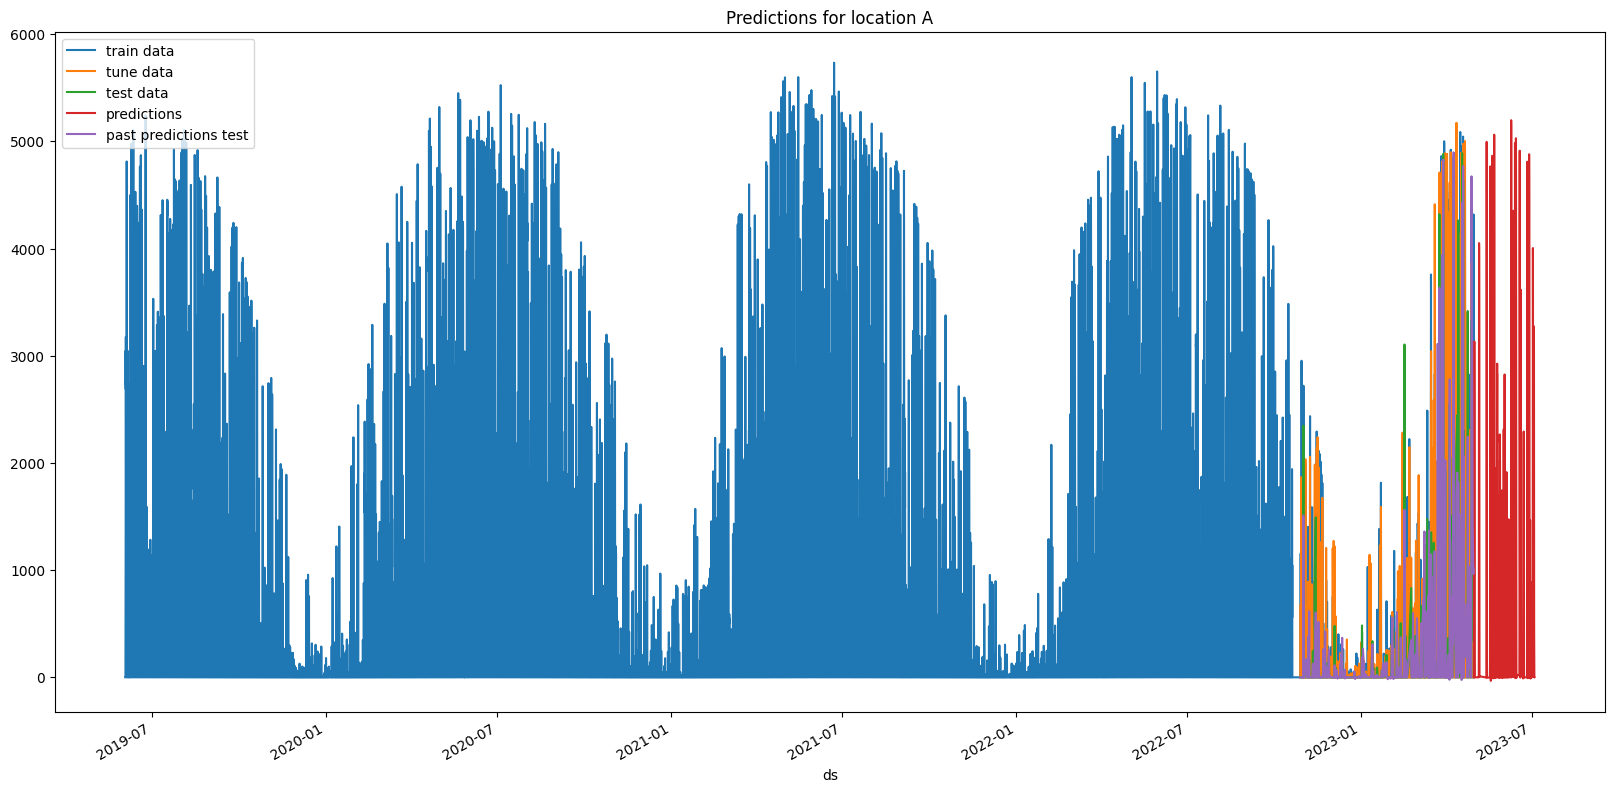

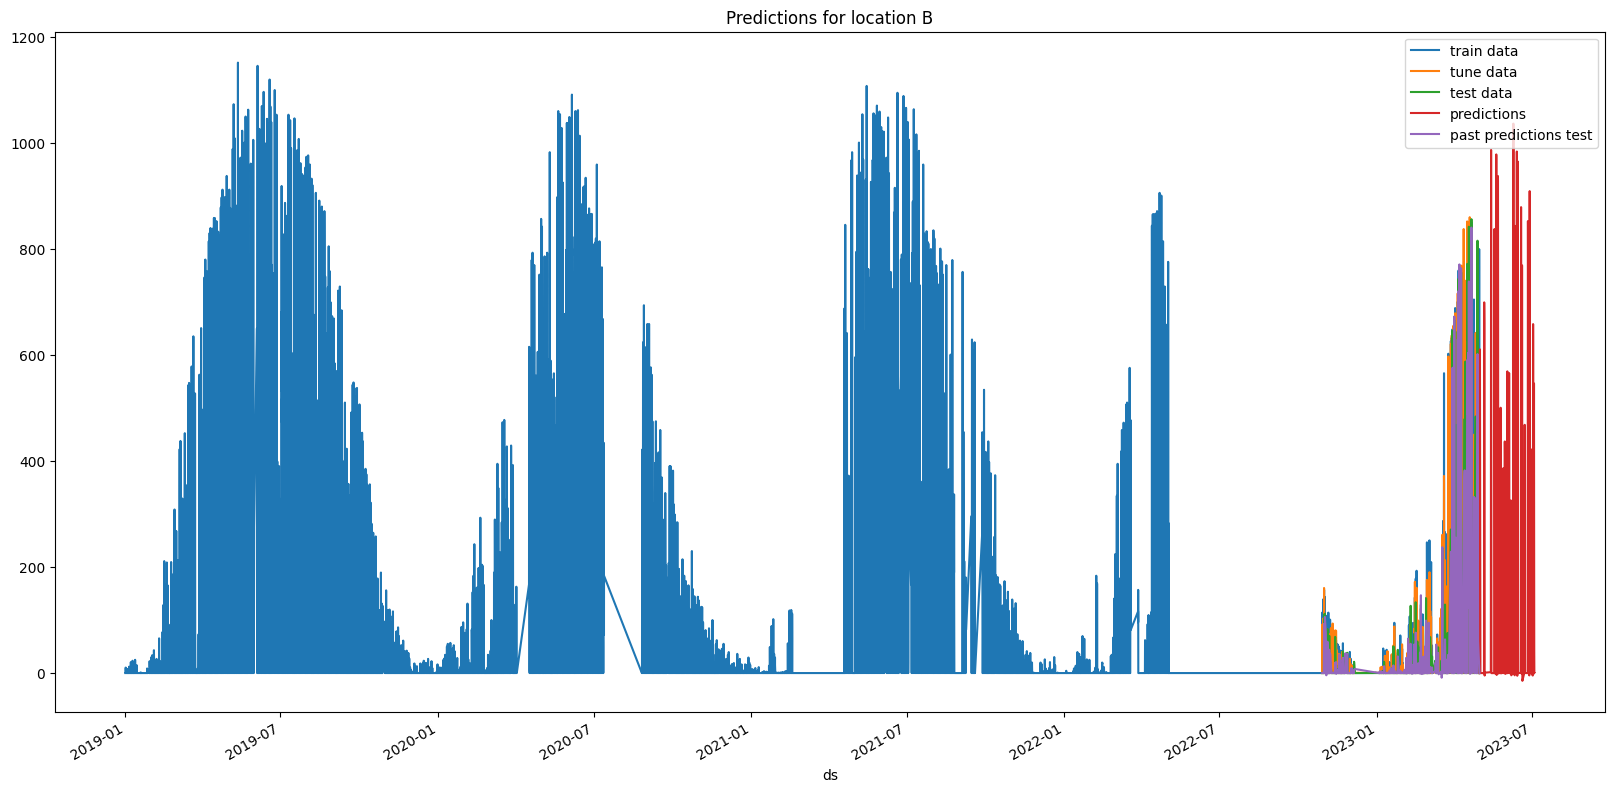

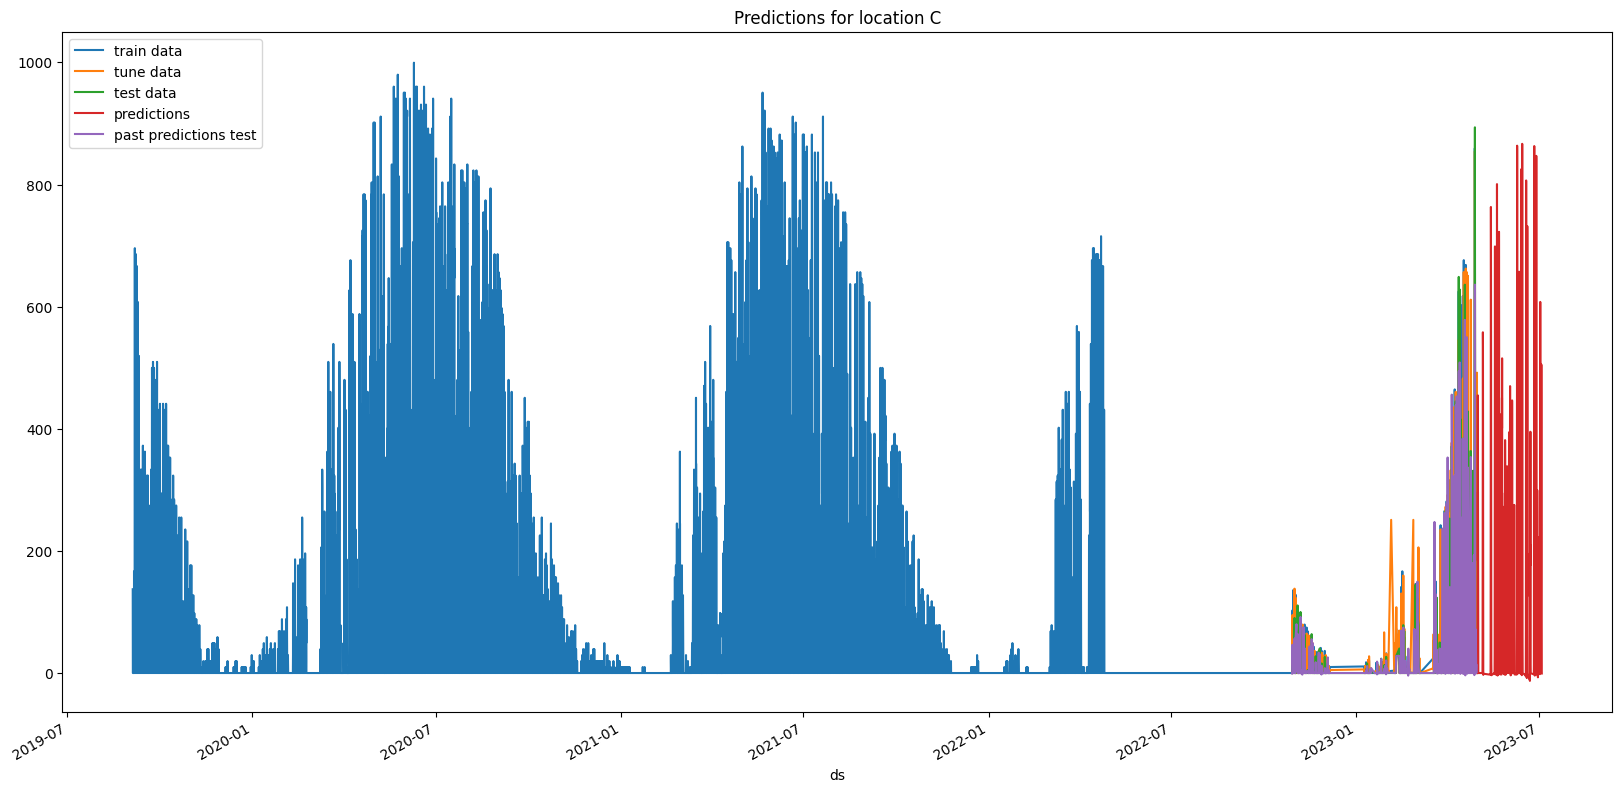

In [ ]:
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data[train_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")
    tuning_data[tuning_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="tune data")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="test data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # plot past predictions
    #tuning_data[tuning_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions tune")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions test")


    ax.set_title(f"Predictions for location {loc}")

In [ ]:
temp_predictions = [prediction.copy() for prediction in predictions]
if clip_predictions:
    # clip predictions smaller than 0 to 0
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        pred.loc[pred["prediction"] < 0, "prediction"] = 0
        print("Smallest prediction after clipping:", pred["prediction"].min())


# concatenate predictions
submissions_df = pd.concat(temp_predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

Smallest prediction: -33.27312124028203
Smallest prediction after clipping: 0.0
Smallest prediction: -14.637827329574803
Smallest prediction after clipping: 0.0
Smallest prediction: -12.85652563130089
Smallest prediction after clipping: 0.0


,id,prediction
0,0,0.000000
1,1,0.001584
2,2,2.016879
3,3,57.978867
4,4,333.737278
...,...,...
715,2155,49.741314
716,2156,35.384108
717,2157,11.543805
718,2158,2.072250


In [ ]:
# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

Saving submission to submissions/submission_137.csv


In [ ]:
# # save this notebook to submissions folder
# import subprocess
# import os
# subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "short_1.ipynb"])